# Hyperparameter Search for RWW Model Fitting

Fit the RWW Model on ADNI healthy patient data. Use an Optuna study to find the best hyperparameters

In [8]:
from whobpyt.datatypes import par, Recording
from whobpyt.models.RWW import RNNRWW, ParamsRWW
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
from sklearn.model_selection import train_test_split

# array and pd stuff
import numpy as np
from scipy.io import loadmat # for reading in the .mat files
import optuna
import torch

# viz stuff
import matplotlib.pyplot as plt

In [9]:
def get_avg_fc(fcs):
    corr_matrices = []

    for data in fcs:
        fc = np.corrcoef(data.T)
        corr_matrices.append(fc)

    stacked_corr = np.stack(corr_matrices, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [10]:
def get_avg_fmr(fmris):
    stacked_corr = np.stack(fmris, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [11]:
sc = np.genfromtxt('data/DTI_fiber_consensus_HCP.csv', delimiter=',')

with open('data/healthy_subjs.txt', 'r') as file:
    fc_files = file.readlines()

fc_files = [file.strip() for file in fc_files]

fcs = []

for f in fc_files:
    fc = loadmat(f)
    fc = fc['ROI_activity'][:100, :]   # get first 100 regions: Schaefer
    if fc.shape[1] == 197:            # get all scans that are 197 long
        fc = fc.T
        fcs.append(fc)

print(len(fcs))

# normalise all fcs - zscore
for i, fc in enumerate(fcs):
    fcs[i] = (fc - fc.mean(axis=0)) / fc.std(axis=0)

train_data, test_data = train_test_split(fcs, test_size=0.2, random_state=42)

print('Training set: ', len(train_data))
print('Test set: ', len(test_data))

366
Training set:  292
Test set:  74


In [21]:
tr = 0.75
ts_length = train_data[0].shape[0]

SC = (sc + sc.T) * 0.5
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

fc_emp_train = get_avg_fc(train_data)
fc_emp_test = get_avg_fc(test_data)


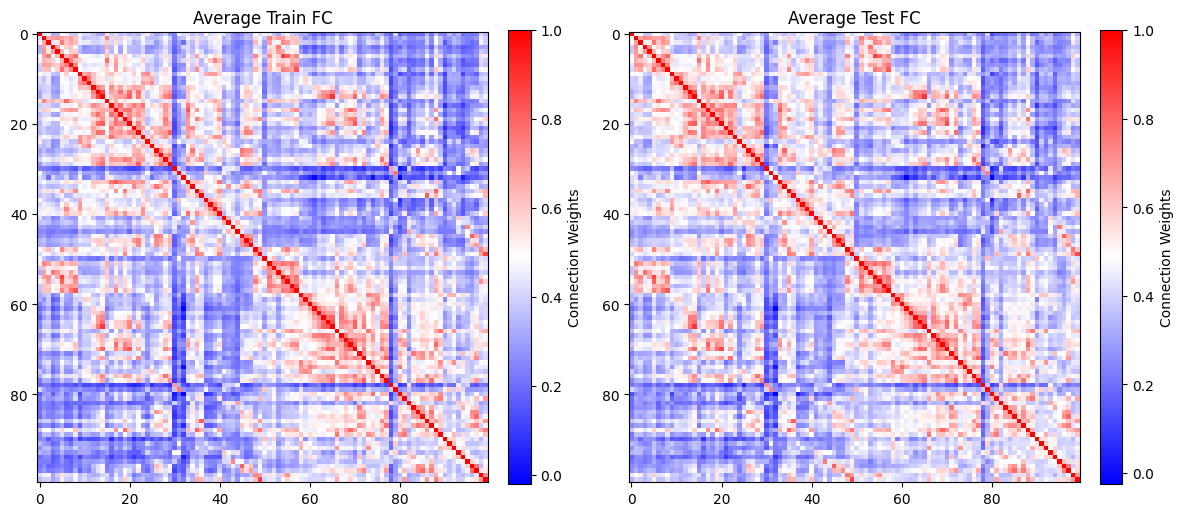

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
im0 = ax[0].imshow(fc_emp_train, cmap='bwr')
ax[0].set_title('Average Train FC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')

im0 = ax[1].imshow(fc_emp_test, cmap='bwr')
ax[1].set_title('Average Test FC')
fig.colorbar(im0, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')



## Optuna Study

In [18]:
def train_model(TPperWindow, step_size, repeat_size, tr, num_epochs, learning_rate, g, ts_length, node_size=100):

    params = ParamsRWW(g=par(g, g, 1/np.sqrt(10), True, True), g_EE=par(3.5, 3.5, 1/np.sqrt(50)), g_EI =par(0.42, 0.42, 1/np.sqrt(50)), \
                   g_IE=par(0.42, 0.42, 1/np.sqrt(50)), I_0 =par(0.2), std_in=par(0.0), std_out=par(0.00))
    
    # call model want to fit
    model = RNNRWW(node_size, TPperWindow, step_size, repeat_size, tr, sc, True, params)
    
    # create objective function
    ObjFun = CostsRWW(model)

    # call model fit
    F = Model_fitting(model, ObjFun)

    # Train on training set
    F.train(u = 0, empFcs= [torch.from_numpy(fc_emp_train)], num_epochs = num_epochs, num_windows = int(ts_length / TPperWindow), learningrate = learning_rate)

    # Test on test set
    _, fc_sim = F.simulate(u = 0, num_windows=int(ts_length/TPperWindow), base_window_num = 20)

    fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])

    return fc_cor

In [15]:
def objective(trial):
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.05, 0.1])
    num_epochs = trial.suggest_categorical('num_epochs', [20, 50, 100])
    step_size = trial.suggest_categorical('step_size', [0.01, 0.05, 0.1])
    g = trial.suggest_categorical('G', [80, 100, 500, 1000])
    score = train_model(TPperWindow=20, step_size=step_size, repeat_size=5, tr=tr, g=g, num_epochs=num_epochs, ts_length=ts_length, learning_rate=learning_rate)
    return score

In [16]:
study = optuna.create_study(direction='maximize')  # or 'minimize' depending on your objective

[I 2024-05-14 10:05:08,462] A new study created in memory with name: no-name-ee83eace-a5c3-416a-9932-bb844c87b809


In [22]:
study.optimize(objective, n_trials=1, n_jobs=1)  # You can specify the number of trials

best_params = study.best_params
best_score = study.best_value

print(best_params)
print(best_score)

Epoch:  0
epoch:  0 loss: 10.548120221546272 Pseudo FC_cor:  0.16413777760789805
Epoch:  1
epoch:  1 loss: 7.792400232545344 Pseudo FC_cor:  0.2391215255527088
Epoch:  2
epoch:  2 loss: 7.76749640640358 Pseudo FC_cor:  0.23009325090259178
Epoch:  3
epoch:  3 loss: 8.019739910944303 Pseudo FC_cor:  0.2178876203610652
Epoch:  4
epoch:  4 loss: 6.868167249238884 Pseudo FC_cor:  0.22431689608967964
Epoch:  5
epoch:  5 loss: 7.205750132605857 Pseudo FC_cor:  0.27814803089301265
Epoch:  6
epoch:  6 loss: 7.2053765765849525 Pseudo FC_cor:  0.23110854821122878
Epoch:  7
epoch:  7 loss: 6.577480536796643 Pseudo FC_cor:  0.29171546208044147
Epoch:  8
epoch:  8 loss: 6.318925504900648 Pseudo FC_cor:  0.19073939148668825
Epoch:  9
epoch:  9 loss: 6.87828589434429 Pseudo FC_cor:  0.2569605158479875
Epoch:  10
epoch:  10 loss: 6.588148290349974 Pseudo FC_cor:  0.3349566918434858
Epoch:  11
epoch:  11 loss: 6.180225006852012 Pseudo FC_cor:  0.2691048799654033
Epoch:  12
epoch:  12 loss: 6.93477573506

[I 2024-05-14 10:13:52,251] Trial 3 finished with value: 0.37449929769670615 and parameters: {'learning_rate': 0.05, 'num_epochs': 20, 'step_size': 0.1, 'G': 500}. Best is trial 3 with value: 0.37449929769670615.


Pearson Correlations:  0.37449929769670615
{'learning_rate': 0.05, 'num_epochs': 20, 'step_size': 0.1, 'G': 500}
0.37449929769670615
